# 1. (모델링) 환경 준비

In [1]:
from matplotlib import pyplot as plt
from datetime import datetime as dt

import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt


In [2]:
data = pd.read_csv('klpga_train.csv', encoding = 'cp949')

# 2. (모델링) 전처리

In [625]:
######################### 사전 제거 컬럼
data.drop(['event_code', 'rank_str', 'series_code','event_yard', 'birdie', 'pBreak', 'days', 'prize_cumsum', 'max_prize',
          'min_prize', 'degree','rank', 'DEA_vrs', 'closeness', 'betweenness','eigenvector',
          'prize', 'sixty', 'avgBirdie', 'avgPut', 'prize_cumsum_1_hhi', 'prize_cumsum_1_gini',
              'drivGIR', 'driving', 'avgStrokePerYard', 'iron', 'p4GIR', 'point', 'prize',
          'p3GIR', 'all', 'GIR', 'fieldPut', 'p3Score', 'p5Score', 'p4Score', 'event_par'], axis = 1, inplace = True)

In [626]:
# IQR outlier 제거 함수
def get_outlier(df = None, column = None, weight = 1.5):
    Q1 = np.percentile(df[column].values, 25)
    Q3 = np.percentile(df[column].values, 75)

    IQR = Q3 - Q1
    IQR_weight = IQR * weight

    lowest = Q1 - IQR_weight
    highest = Q3 + IQR_weight

    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    
    return outlier_idx

In [627]:
# 변수 중 수치형 데이터
NUMVlists = []

for col in data.columns:
    if type(data[col][0]) != type('문자열'):
        NUMVlists.append(col)
        
# 아래 변수 세개는 IQR 이상치제거에서 데이터를 너무 많이      
NUMVlists.remove('rookieP')
NUMVlists.remove('top10')
NUMVlists.remove('top1')
NUMVlists.remove('top2')
NUMVlists.remove('eagle')

In [628]:
data.shape # (25460, 62)

(25460, 41)

In [629]:
for NUMVlist in NUMVlists:
    outlier_idx = get_outlier(df = data, column = NUMVlist, weight = 3) 
    data.drop(outlier_idx, axis=0, inplace=True)

In [630]:
data.shape

(22146, 41)

C:\Users\H&CONSULTING\AppData\Local\Temp\ipykernel_14176\960061671.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  graph = sns.distplot(data['avgStroke'],


Skewness(왜도): 0.472594
Kurtosis(첨도): 0.449201


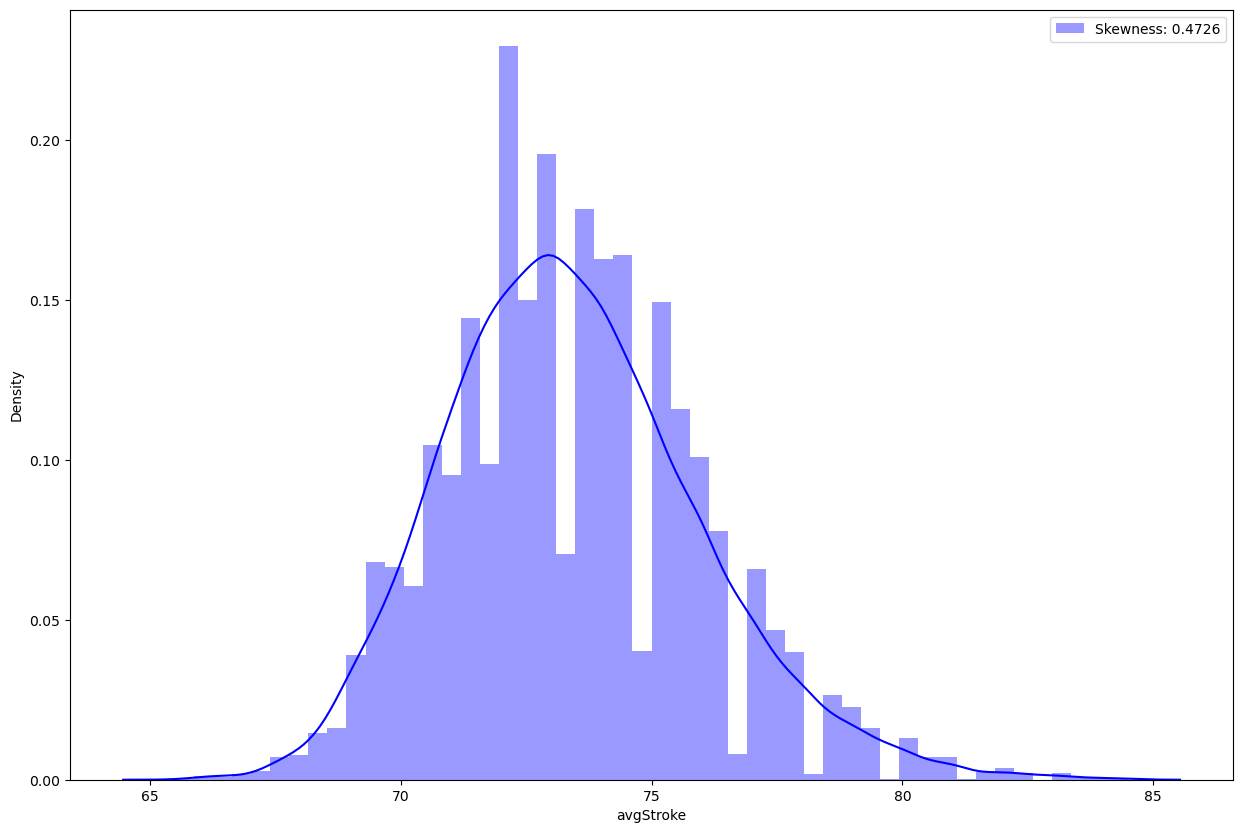

In [617]:
# avgStroke 왜도 첨도 확인
plt.figure(figsize=(15,10))

graph = sns.distplot(data['avgStroke'],
                    color = 'b',
                    label = 'Skewness: %.4f' %data['avgStroke'].skew())

graph = graph.legend(loc = 'best')

print('Skewness(왜도): %f' %data['avgStroke'].skew())
print('Kurtosis(첨도): %f' %data['avgStroke'].kurt())

In [631]:
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')
data['year'] = pd.to_datetime(data['year'], format = '%Y')
data['month'] = pd.to_datetime(data['month'], format = '%m')

In [632]:
data = data.sort_values(by = ['date'], axis = 0, ascending = True)
data.drop(['year', 'month'], axis = 1, inplace = True)
data.index = data['date']
data.drop('date', axis = 1, inplace = True)

# 3. (모델링) ML

In [633]:
type(data['avgStroke'])

pandas.core.series.Series

In [634]:
def load_data(data):
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    
    scaler = MinMaxScaler()
    
    X = data 
    y = X.pop('avgStroke')
    
    scaled_data = scaler.fit_transform(data.select_dtypes(exclude=["object", "category"]))
    df_scaled = pd.DataFrame(data=scaled_data, columns=data.select_dtypes(exclude=['object', 'category']).columns)
    X = df_scaled.copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.2, 
                                                      shuffle = False)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data(data)
print('Train Data :',len(X_train))
print('Test Data :',len(y_test))
y_train.head()

Train Data : 17716
Test Data : 4430


date
2008-04-13    73.3333
2008-04-13    73.0000
2008-04-13    76.0000
2008-04-13    73.3333
2008-04-13    72.3333
Name: avgStroke, dtype: float64

In [346]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
!pip install xgboost
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

!pip install catboost
from catboost import CatBoostRegressor

In [635]:
# KNN
model = KNeighborsRegressor(n_neighbors = 50)
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
score_r2 = r2_score(y_test, y_predicted)
score_mae = mean_absolute_error(y_test, y_predicted)
print("--- KNN ---")
print("Score r2: {}".format(r2_score(y_test, y_predicted)))
print("MAE : {}".format(mean_absolute_error(y_test, y_predicted)))


# Linear
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
score_r2 = r2_score(y_test, y_predicted)
score_mae = mean_absolute_error(y_test, y_predicted)
print("--- Linear Regression ---")
print("Score r2: {}".format(r2_score(y_test, y_predicted)))
print("MAE : {}".format(mean_absolute_error(y_test, y_predicted)))

# XGB
model = XGBRegressor(n_jobs=5, learning_rate=0.1, max_depth=10, random_state=1)
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
score_r2 = r2_score(y_test, y_predicted)
score_mae = mean_absolute_error(y_test, y_predicted)
print("--- XGB ---")
print("Score r2: {}".format(r2_score(y_test, y_predicted)))
print("MAE : {}".format(mean_absolute_error(y_test, y_predicted)))

# CatBoost
model = CatBoostRegressor(logging_level ='Silent',iterations=500,random_state=1)
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
score_r2 = r2_score(y_test, y_predicted)
score_mae = mean_absolute_error(y_test, y_predicted)
print("--- CB ---")
print("Score r2: {}".format(r2_score(y_test, y_predicted)))
print("MAE : {}".format(mean_absolute_error(y_test, y_predicted)))


--- KNN ---
Score r2: 0.6977513824515509
MAE : 1.0863113525959367
--- Linear Regression ---
Score r2: 0.8336031594397861
MAE : 0.7819307538852025
--- XGB ---
Score r2: 0.81870106381494
MAE : 0.820591911505361
--- CB ---
Score r2: 0.8384724334016428
MAE : 0.7665540056368624


In [636]:
model = CatBoostRegressor(logging_level ='Silent',iterations=500,random_state=1)
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

In [637]:
print(model.predict(X_test))

[75.03077777 75.93995213 71.24707753 ... 70.29588338 69.87218419
 71.02186128]


In [638]:
data.columns

Index(['name', 'event_name', 'event_meter', 'rookieP', 'holeInOne', 'eagle',
       'p3avgBirdie', 'p4avgBirdie', 'p5avgBirdie', 'drivAcc', 'driveDist',
       'p3Put', 'p4Put', 'p5Put', 'p5GIR', 'bunkSave', 'recovery', 'top10',
       'hit', 'avgHoleInOne', 'avgEagle', 'round', 'birth', 'height',
       'sponsor', 'age', 'event_cumsum', 'prize_cumsum_1', 'prize_gini',
       'prize_hhi', 'career', 'top1', 'top2', 'total_prize',
       'prize_cumsum_gini', 'prize_cumsum_hhi', 'DEA_crs'],
      dtype='object')

# 4. (실전테스트) ML -  (~2021까지 학습)

In [639]:
data2 = pd.read_csv('klpga_test.csv', encoding = 'cp949')

C:\Users\H&CONSULTING\AppData\Local\Temp\ipykernel_14176\3174890865.py:1: DtypeWarning: Columns (0,3,5,6,49,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data2 = pd.read_csv('klpga_test.csv', encoding = 'cp949')


In [640]:
data2.shape

(24365, 77)

In [641]:
data2 = data2.sort_values(by = ['date'], axis = 0, ascending = False)

In [642]:
data2 = data2.loc[:,['name', 'event_name',
       'event_meter', 'rookieP', 'holeInOne', 'eagle', 'p3avgBirdie',
       'p4avgBirdie', 'p5avgBirdie', 'drivAcc', 'driveDist', 'p3Put', 'p4Put',
       'p5Put', 'p5GIR', 'bunkSave', 'recovery', 'top10', 'hit',
       'avgHoleInOne', 'avgEagle', 'round', 'birth', 'height', 'sponsor',
       'age', 'event_cumsum', 'prize_cumsum_1', 'prize_gini', 'prize_hhi',
       'career', 'top1', 'top2', 'total_prize', 'prize_cumsum_gini',
       'prize_cumsum_hhi', 'DEA_crs']]

In [643]:
data2.dropna(inplace=True)

In [644]:
data2.shape

(1095, 37)

In [645]:
data2.head()

,name,event_name,event_meter,rookieP,holeInOne,eagle,p3avgBirdie,p4avgBirdie,p5avgBirdie,drivAcc,...,prize_cumsum_1,prize_gini,prize_hhi,career,top1,top2,total_prize,prize_cumsum_gini,prize_cumsum_hhi,DEA_crs
1094,황정미,셀트리온 퀸즈 마스터즈,6106.0,0.0,0.0,1.0,16.6667,20.0,25.0,80.95,...,20.378583,0.950152,0.3,10.0,0.0,0.0,20.905587,0.0532,0.0,0.906941
1021,박지영,셀트리온 퀸즈 마스터즈,6106.0,0.0,0.0,0.0,16.6667,10.0,50.0,73.81,...,21.722871,0.950152,0.3,9.0,0.0,0.0,20.905587,0.0532,0.0,0.897082
1009,나희원,셀트리온 퀸즈 마스터즈,6106.0,0.0,0.0,0.0,12.5000,0.0,37.5,42.86,...,20.645122,0.950152,0.3,9.0,0.0,0.0,20.905587,0.0532,0.0,0.000008
1010,노승희,셀트리온 퀸즈 마스터즈,6106.0,0.0,0.0,0.0,12.5000,5.0,37.5,89.29,...,19.894469,0.950152,0.3,10.0,0.0,0.0,20.905587,0.0532,0.0,0.000007
1011,마다솜,셀트리온 퀸즈 마스터즈,6106.0,0.0,0.0,0.0,37.5000,15.0,12.5,67.86,...,19.812092,0.950152,0.3,9.0,0.0,0.0,20.905587,0.0532,0.0,0.000008


In [646]:
data2['event_name'].unique()

array(['셀트리온 퀸즈 마스터즈', '롯데 오픈', '제11회 E1 채리티 오픈', '2023 NH투자증권 레이디스 챔피언십',
       '제9회 교촌 1991 레이디스 오픈', '크리스에프앤씨 제45회 KLPGA 챔피언십',
       '넥센 · 세인트나인 마스터즈 2023', '메디힐 · 한국일보 챔피언십', '롯데렌터카 여자오픈'],
      dtype=object)

In [647]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data2.select_dtypes(exclude=["object", "category"]))
df_scaled = pd.DataFrame(data=scaled_data, columns=data2.select_dtypes(exclude=['object', 'category']).columns)
X = df_scaled.copy()

In [680]:
model = CatBoostRegressor(logging_level ='Silent',iterations=500,random_state=1)
model.fit(X_train, y_train)
Prediction = model.predict(X)
print(Prediction)

[70.59268798 71.88528606 79.58377149 ... 78.49587343 71.59623354
 73.67735837]


In [681]:
data2['Pred'] = Prediction
data2 = data2.loc[:,['name', 'event_name', 'Pred']]
data2 = data2.sort_index(ascending = True)
data2.head()

,name,event_name,Pred
0,LI Shuying,롯데렌터카 여자오픈,79.576971
1,강채연,롯데렌터카 여자오픈,73.928769
2,고지우,롯데렌터카 여자오픈,77.076622
3,고지원,롯데렌터카 여자오픈,74.764821
4,곽보미,롯데렌터카 여자오픈,79.005096


In [682]:
data2

,name,event_name,Pred
0,LI Shuying,롯데렌터카 여자오픈,79.576971
1,강채연,롯데렌터카 여자오픈,73.928769
2,고지우,롯데렌터카 여자오픈,77.076622
3,고지원,롯데렌터카 여자오픈,74.764821
4,곽보미,롯데렌터카 여자오픈,79.005096
...,...,...,...
1090,홍진영2,셀트리온 퀸즈 마스터즈,73.207609
1091,황연서,셀트리온 퀸즈 마스터즈,76.116411
1092,황예나,셀트리온 퀸즈 마스터즈,72.470541
1093,황유민,셀트리온 퀸즈 마스터즈,70.860217


# 5. 셀통합

In [683]:
data3 = pd.read_csv('klpga_test.csv', encoding = 'cp949')
data3.dropna(inplace=True)
data3 = data3.loc[:,['avgStroke']]

C:\Users\H&CONSULTING\AppData\Local\Temp\ipykernel_14176\2857187676.py:1: DtypeWarning: Columns (0,3,5,6,49,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data3 = pd.read_csv('klpga_test.csv', encoding = 'cp949')


In [684]:
data3

,avgStroke
0,73.5000
1,75.7500
2,75.0000
3,76.0000
4,79.0000
...,...
1090,71.6667
1091,71.6667
1092,75.5000
1093,69.6667


# 6. 파일화

In [687]:
data2 = data2.sort_values(by = ['Real'] , axis = 0, ascending = True)
data2

,name,event_name,Pred,Real
679,임진희,2023 NH투자증권 레이디스 챔피언십,70.592688,67.0000
632,박지영,2023 NH투자증권 레이디스 챔피언십,71.885286,67.3333
635,방신실,2023 NH투자증권 레이디스 챔피언십,79.583771,67.6667
669,이예원,2023 NH투자증권 레이디스 챔피언십,78.476719,67.6667
1016,박민지,셀트리온 퀸즈 마스터즈,76.306977,68.3333
...,...,...,...,...
90,정주원,롯데렌터카 여자오픈,77.673134,82.0000
196,장하나,메디힐 · 한국일보 챔피언십,78.495873,82.5000
281,안지현,넥센 · 세인트나인 마스터즈 2023,73.911538,82.5000
204,정주원,메디힐 · 한국일보 챔피언십,71.596234,83.0000


In [688]:
data2.to_excel('KLPGA_Prediction.xlsx',encoding = 'utf-8')

C:\Anaconda\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)
